# Imports

In [1]:
import os

import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

# Choose indicator by uncommenting one of the following lines
indicator = 'calcium'
# indicator = 'glutamate'

database.connect_dj(indicator=indicator)
clear_output()

In [3]:
morph_tab = database.get_morph_tab()
field_tab = database.get_field_tab()
roi_pos_tab = database.get_roi_pos_tab()
rf_tab = database.get_rf_tab()

In [4]:
_, field_avg_dx, field_avg_dy = database.get_field_avg_offset()

## Cell and ROI selection

In [5]:
if indicator == 'calcium':
    cell_and_rois = {
        ('20200608', 1): [(2, 1), (4, 1)],
        ('20200510', 1): [(5, 1), (2, 5)],
        ('20200511', 1): [(6, 1), (4, 1)]}
else:
    cell_and_rois = {
        ('20201110', 2): [(4, 5), (3, 2), (1, 4)],
        ('20201103', 1): [(4, 1), (2, 1), (3, 1)]}

In [6]:
exp_keys = [dict(date=date, exp_num=exp_num) for date, exp_num in cell_and_rois.keys()]

# Plot

In [7]:
palettes = {}

for (cell, rois), colormap in zip(
        cell_and_rois.items(),
        ['Oranges_r', 'Blues_r', 'Greens_r'] if indicator == 'calcium' else ['Oranges_r', 'Greens_r']
):
    palettes[cell] = sns.color_palette(colormap, n_colors=1 + len(rois))

In [8]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [9]:
FIGURE_FOLDER = 'figures'

## Plot sRF outlines on morph

In [10]:
flip_rf_y = indicator=='glutamate'  # Stimulus was flipped on this setup, so we need to correct for this

In [11]:
def get_add_offset(cell):
    """Correct with field avg offset"""
    date, exp_num = cell
    date = f"{date[:4]}-{date[4:6]}-{date[6:8]}"
    return -field_avg_dx.loc[date, exp_num], - field_avg_dy.loc[date, exp_num]

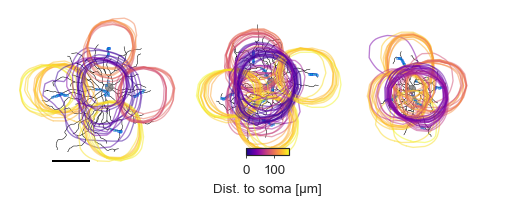

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

if indicator == 'calcium':
    fig, axs = plt.subplots(1, len(cell_and_rois), figsize=(4.5, 2.5), sharex='all')
else:
    fig, axs = plt.subplots(len(cell_and_rois), 1, figsize=(1.3, 2.6), sharey='all')

for i, (cell, highlight_list) in enumerate(cell_and_rois.items()):
    offset = get_add_offset(cell)
    
    sm = plota.plot_rois_on_morph(
        axs[i], cell, [], 'contour',
        morph_tab, rf_tab, roi_pos_tab, field_tab,
        annotate=True, plot_srf_contours=True, plot_srf_offset=False, plot_rf_rois_only=True,
        roi_kws=dict(ms=3, alpha=0.5, mew=0.25, mec='b'),
        rf_contour_kws=dict(lw=0.8, zorder=1000), palettes=palettes,
        stim_offset_xy_um=(-15, +15 if flip_rf_y else -15),
        add_offset_rf_xy_um=(offset[0], -offset[1] if flip_rf_y else +offset[1]),
        flip_rf_y=flip_rf_y,
        offset_kws=dict(c='gray', lw=1),
        cmap='plasma',
    )

plota.plot_scale_bar(axs[0], x0=50, y0=0, size=100, pad=-10, text='', orientation='h')   

if indicator == 'calcium':
    plt.tight_layout(w_pad=0)
    plota.move_box(axs[-1], dx=-0.05)
    cax = inset_axes(axs[1], width="25%", height="5%", loc='lower center')
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', label='Dist. to soma [µm]')
else:
    plt.tight_layout(w_pad=0, h_pad=-2, rect=(0, 0.2, 1, 1))
    cax = inset_axes(axs[-1], width="50%", height="5%", loc='lower center', borderpad=-1.0)
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', label='Dist. to soma [µm]')

fig.savefig(os.path.join(FIGURE_FOLDER, f'example_cells_with_rfs_{indicator}.pdf'))